<a id='top'></a>

# Record Linkage of StatsBomb and TransferMarkt Datasets
##### Notebook to join the scraped datasets from [StatsBomb](https://StatsBomb.com/en/) and [TransferMarkt](https://www.transfermarkt.co.uk/),  through [record-linkage](https://pypi.org/project/recordlinkage/), to create one, unified source of information, that can be used for for further analysis of players performance statistics and financial valuations.

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 20/07/2021<br>
Notebook last updated: 20/07/2021

![title](../../img/stats-bomb-logo.png)

![title](../../img/transfermarkt-logo-banner.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook joins datasets from [StatsBomb](https://statsbomb.com/) and [TransferMarkt](https://www.transfermarkt.co.uk/) (scraped using the [Tyrone Mings web scraper](https://github.com/FCrSTATS/tyrone_mings) by [FCrSTATS](https://twitter.com/FC_rstats)) through [RecordLinkage](https://pypi.org/project/recordlinkage/), to create one, unified source of information, that can be used for to enrich existing StatsBomb data analysis with player financial valuations. This data is manipulated as DataFrames using [pandas](http://pandas.pydata.org/).

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here]().

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
4.    [Record Linkage](#section4)<br>
      1.    [Introduction](#section4.1)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`RecordLinkage`](https://pypi.org/project/recordlinkage/) for joining of fuzzy datasets; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd    # version 1.0.3
import os    #  used to read the csv filenames
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno    # visually display missing data

# Progress Bar
from tqdm import tqdm    # a clean progress bar library

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print("Setup Complete")

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Define Data Paths

In [131]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_sb = os.path.join(base_dir, 'data', 'sb')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
data_dir_sb_tm = os.path.join(base_dir, 'data', 'sb-tm')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Notebook Settings

In [132]:
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to fuzzy match scraped football data from [StatsBomb](https://statsbomb.com/), and [TransferMarkt](https://www.transfermarkt.co.uk/), using [RecordLinkage](https://pypi.org/project/recordlinkage/) and [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames.

The aims of this notebook is to result in two, finalised datasets of players and goalkeepers, exported to CSV. This data can be further analysis using python (see [Section 6](#section6) of this notebook), or can be explored using Tableau, PowerBI, Microsoft Excel. These datasets are the following:
*    outfield players
*    goalkeepers

The data used in this notebooks has been scraped using the [StatsBomb]() and [TransferMarkt]() webscraping notebooks.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
This Data Sources section has been has been split into two subsections for theStatsBomb and TransferMarkt datasets.

Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and Cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. StatsBomb</a>

#### <a id='#section3.2.1'>3.2.1. Import the Datasets</a>

In [9]:
# Import DataFrame as a CSV file
df_sb = pd.read_csv(data_dir + '/sb/engineered/combined/wc2018/sb_events_grouped_position.csv')

In [37]:
df_sb.head()

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper
0,Aaron Mooy,Australia,Left Center Midfield,Midfield,Outfielder
1,Abdalla Mahmoud El Said Bekhit,Egypt,Center Attacking Midfield,Midfield,Outfielder
2,Abdiel Arroyo Molinar,Panama,Left Center Midfield,Midfield,Outfielder
3,Abdullah Ibrahim Al Maiouf,Saudi Arabia,Goalkeeper,Goalkeeper,Goalkeeper
4,Abdullah Ibrahim Otayf,Saudi Arabia,Center Defensive Midfield,Midfield,Outfielder


In [38]:
df_sb['name_lower'] = (df_sb['player_name'].str.normalize('NFKD')
                            .str.encode('ascii', errors='ignore')
                            .str.decode('utf-8')
                            .str.lower()
                      )

# First Name Lower
df_sb['firstname_lower'] = df_sb['name_lower'].str.rsplit(' ', 0).str[0]

# Last Name Lower
df_sb['lastname_lower'] = df_sb['name_lower'].str.rsplit(' ', 1).str[-1]

# First Initial Lower
df_sb['firstinitial_lower'] = df_sb['name_lower'].astype(str).str[0]

In [39]:
df_sb['country'] = df_sb['team_name']

# Remove accents and create lowercase name
df_sb['country_lower'] = (df_sb['country']
                             .str.normalize('NFKD')
                               .str.encode('ascii', errors='ignore')
                               .str.decode('utf-8')
                               .str.lower()
                           )

In [40]:
df_sb.head()

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper,name_lower,firstname_lower,lastname_lower,firstinitial_lower,country,country_lower
0,Aaron Mooy,Australia,Left Center Midfield,Midfield,Outfielder,aaron mooy,aaron,mooy,a,Australia,australia
1,Abdalla Mahmoud El Said Bekhit,Egypt,Center Attacking Midfield,Midfield,Outfielder,abdalla mahmoud el said bekhit,abdalla,bekhit,a,Egypt,egypt
2,Abdiel Arroyo Molinar,Panama,Left Center Midfield,Midfield,Outfielder,abdiel arroyo molinar,abdiel,molinar,a,Panama,panama
3,Abdullah Ibrahim Al Maiouf,Saudi Arabia,Goalkeeper,Goalkeeper,Goalkeeper,abdullah ibrahim al maiouf,abdullah,maiouf,a,Saudi Arabia,saudi arabia
4,Abdullah Ibrahim Otayf,Saudi Arabia,Center Defensive Midfield,Midfield,Outfielder,abdullah ibrahim otayf,abdullah,otayf,a,Saudi Arabia,saudi arabia


#### <a id='#section3.2.2'>3.2.2. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [41]:
# Display the first 5 rows of the raw DataFrame, df_sb
df_sb.head()

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper,name_lower,firstname_lower,lastname_lower,firstinitial_lower,country,country_lower
0,Aaron Mooy,Australia,Left Center Midfield,Midfield,Outfielder,aaron mooy,aaron,mooy,a,Australia,australia
1,Abdalla Mahmoud El Said Bekhit,Egypt,Center Attacking Midfield,Midfield,Outfielder,abdalla mahmoud el said bekhit,abdalla,bekhit,a,Egypt,egypt
2,Abdiel Arroyo Molinar,Panama,Left Center Midfield,Midfield,Outfielder,abdiel arroyo molinar,abdiel,molinar,a,Panama,panama
3,Abdullah Ibrahim Al Maiouf,Saudi Arabia,Goalkeeper,Goalkeeper,Goalkeeper,abdullah ibrahim al maiouf,abdullah,maiouf,a,Saudi Arabia,saudi arabia
4,Abdullah Ibrahim Otayf,Saudi Arabia,Center Defensive Midfield,Midfield,Outfielder,abdullah ibrahim otayf,abdullah,otayf,a,Saudi Arabia,saudi arabia


In [42]:
# Display the last 5 rows of the raw DataFrame, df_sb
df_sb.tail()

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper,name_lower,firstname_lower,lastname_lower,firstinitial_lower,country,country_lower
595,İlkay Gündoğan,Germany,Left Defensive Midfield,Midfield,Outfielder,ilkay gundogan,ilkay,gundogan,i,Germany,germany
596,Łukasz Fabiański,Poland,Goalkeeper,Goalkeeper,Goalkeeper,ukasz fabianski,ukasz,fabianski,u,Poland,poland
597,Łukasz Piszczek,Poland,Right Center Back,Defender,Outfielder,ukasz piszczek,ukasz,piszczek,u,Poland,poland
598,Łukasz Teodorczyk,Poland,Center Attacking Midfield,Midfield,Outfielder,ukasz teodorczyk,ukasz,teodorczyk,u,Poland,poland
599,Šime Vrsaljko,Croatia,Right Back,Defender,Outfielder,sime vrsaljko,sime,vrsaljko,s,Croatia,croatia


[shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) returns a tuple representing the dimensionality of the DataFrame.

In [43]:
# Print the shape of the raw DataFrame, df_sb
print(df_sb.shape)

(600, 11)


[columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) returns the column labels of the DataFrame.

In [44]:
# Features (column names) of the raw DataFrame, df_sb
df_sb.columns

Index(['player_name', 'team_name', 'primary_position_name',
       'primary_position_name_grouped', 'outfielder_goalkeeper', 'name_lower',
       'firstname_lower', 'lastname_lower', 'firstinitial_lower', 'country',
       'country_lower'],
      dtype='object')

The [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) method returns the data types of each attribute in the DataFrame.

In [45]:
# Data types of the features of the raw DataFrame, df_sb
df_sb.dtypes

player_name                      object
team_name                        object
primary_position_name            object
primary_position_name_grouped    object
outfielder_goalkeeper            object
name_lower                       object
firstname_lower                  object
lastname_lower                   object
firstinitial_lower               object
country                          object
country_lower                    object
dtype: object

In [46]:
# Displays all one hundered and four columns, commented out but shown for reference
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_sb.dtypes)

player_name                      object
team_name                        object
primary_position_name            object
primary_position_name_grouped    object
outfielder_goalkeeper            object
name_lower                       object
firstname_lower                  object
lastname_lower                   object
firstinitial_lower               object
country                          object
country_lower                    object
dtype: object


The [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) method to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [47]:
# Info for the raw DataFrame, df_sb
df_sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   player_name                    600 non-null    object
 1   team_name                      600 non-null    object
 2   primary_position_name          600 non-null    object
 3   primary_position_name_grouped  600 non-null    object
 4   outfielder_goalkeeper          600 non-null    object
 5   name_lower                     600 non-null    object
 6   firstname_lower                600 non-null    object
 7   lastname_lower                 600 non-null    object
 8   firstinitial_lower             600 non-null    object
 9   country                        600 non-null    object
 10  country_lower                  600 non-null    object
dtypes: object(11)
memory usage: 51.7+ KB


The [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to show some useful statistics for each numerical column in the DataFrame.

In [48]:
# Description of the raw DataFrame, df_sb, showing some summary statistics for each numberical column in the DataFrame
df_sb.describe()

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper,name_lower,firstname_lower,lastname_lower,firstinitial_lower,country,country_lower
count,600,600,600,600,600,600,600,600,600,600,600
unique,600,32,24,4,2,600,446,552,24,32,32
top,Maciej Rybus,Belgium,Center Forward,Midfield,Outfielder,trent sainsbury,jose,silva,m,Belgium,poland
freq,1,21,49,202,559,1,9,8,76,21,21


Next, we will check to see how many missing values we have i.e. the number of NULL values in the dataset, and in what features these missing values are located. This can be plotted nicely using the [missingno](https://pypi.org/project/missingno/) library (pip install missingno).

<AxesSubplot:>

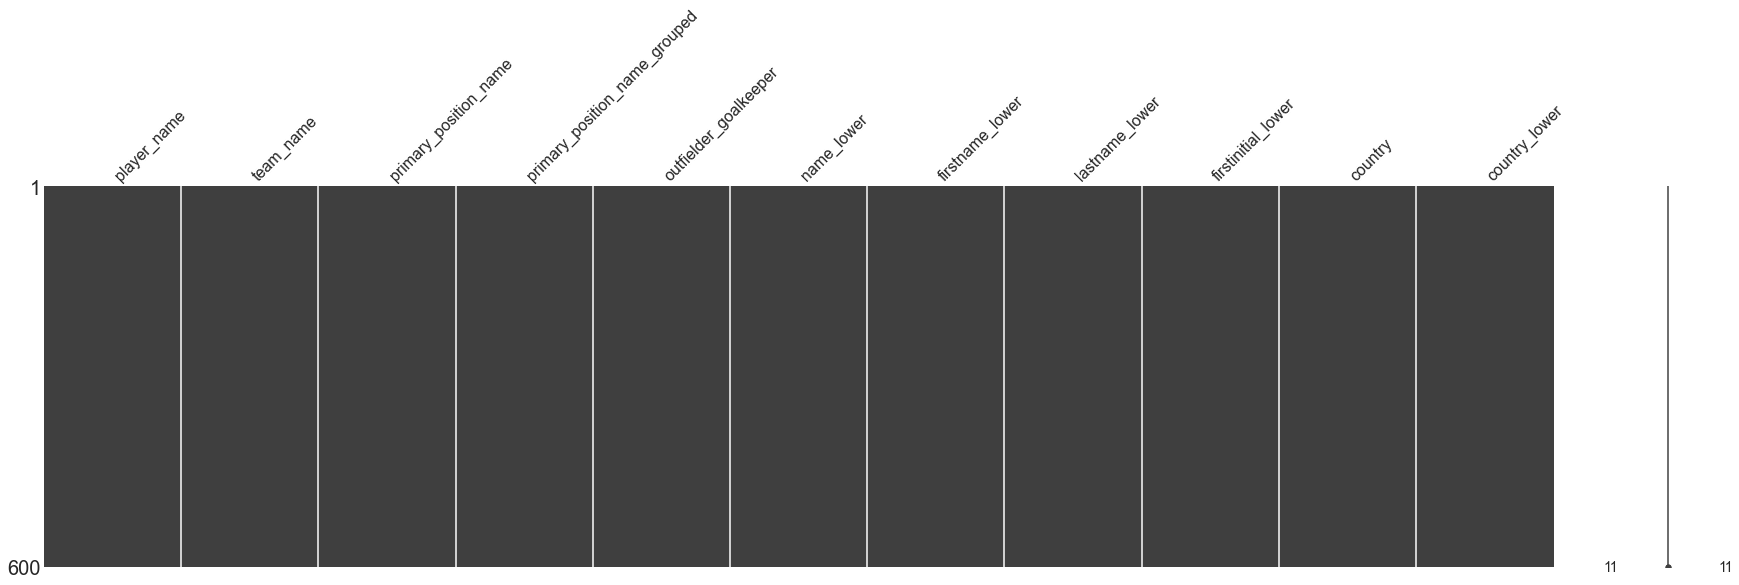

In [49]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_sb
msno.matrix(df_sb, figsize = (30, 7))

In [50]:
# Counts of missing values
null_value_stats = df_sb.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

The visualisation shows us very quickly that there are no missing values in either of the datasets.

### <a id='#section3.3'>3.3. TransferMarkt</a>

In [51]:
# Define season to join

## Assign season to variable
season = '2018'    # '2018' for the 18/19 season

## Create 'Full Season' and 'Short Season' strings

### Full season
full_season_string = str(int(season)) + '/' + str(int(season) + 1)

### Short season
short_season_string = str((str(int(season))[-2:]) + (str(int(season) + 1)[-2:]))

### Short season
season_filter = str((str(int(season))[-2:]) + '/' + (str(int(season) + 1)[-2:]))

In [52]:
full_season_string

'2018/2019'

In [53]:
short_season_string

'1819'

In [54]:
season_filter

'18/19'

#### <a id='#section3.3.1'>3.3.1. Import the Dataset</a>

In [55]:
# Import DataFrame as a CSV file
df_tm = pd.read_csv(data_dir_tm + f'/engineered/{short_season_string}/bio-status/' + f'tm_bio_status_{short_season_string}.csv')

#### <a id='#section3.3.2'>3.3.2. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [56]:
# Display the first 5 rows of the raw DataFrame, df_tm
df_tm.head()

,tm_id,player_name,birth_day,birth_month,birth_year,pob,cob,dob,position,height,foot,citizenship,second_citizenship,current_club,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,name_lower,firstname_lower,lastname_lower,firstinitial_lower,league_country_lower,position_code,position_grouped,outfielder_goalkeeper,age,age_when_joining,years_since_joining,years_until_contract_expiry,market_value_pounds
0,292246,hee-chan hwang,26.0,1.0,1996.0,"Chuncheon, Gangwon","Korea, South",1996-01-26,attack - Centre-Forward,177.0,right,"Korea, South",NaN,rb leipzig,germany,11000000.0,2020-07-15,2025-06-30,NaN,NaN,NaN,NaN,ICM Stellar Sports,hee-chan hwang,hee-chan,hwang,h,germany,ST,Forward,Outfielder,25.0,24.0,1.0,3.0,9900000.0
1,315604,diadié samassékou,11.0,1.0,1996.0,Bamako,Mali,1996-01-11,midfield - Defensive Midfield,177.0,right,Mali,NaN,tsg 1899 hoffenheim,germany,14000000.0,2019-08-15,2024-06-30,NaN,NaN,NaN,NaN,ROOF,diadie samassekou,diadie,samassekou,d,germany,CDM,Midfielder,Outfielder,25.0,23.0,1.0,2.0,12600000.0
2,360140,majeed ashimeru,10.0,10.0,1997.0,Accra,Ghana,1997-10-10,midfield - Central Midfield,182.0,right,Ghana,NaN,rsc anderlecht,belgium,2500000.0,2021-07-01,2025-06-30,NaN,NaN,NaN,NaN,CAA Base Ltd,majeed ashimeru,majeed,ashimeru,m,belgium,CM,Midfielder,Outfielder,23.0,23.0,0.0,3.0,2250000.0
3,307052,masaya okugawa,14.0,4.0,1996.0,"Koka, Shiga",Japan,1996-04-14,midfield - Left Midfield,177.0,both,Japan,NaN,arminia bielefeld,germany,2500000.0,2021-07-01,2024-06-30,NaN,NaN,NaN,NaN,Yu Matoji,masaya okugawa,masaya,okugawa,m,germany,LM,Midfielder,Outfielder,25.0,25.0,0.0,2.0,2250000.0
4,260846,asger sörensen,5.0,6.0,1996.0,Virklund,Denmark,1996-06-05,Defender - Centre-Back,191.0,right,Denmark,NaN,1.fc nuremberg,germany,700000.0,2019-07-06,2022-06-30,NaN,NaN,NaN,NaN,Boutique Transfers,asger sorensen,asger,sorensen,a,germany,CB,Defender,Outfielder,25.0,23.0,2.0,0.0,630000.0


In [57]:
# Display the last 5 rows of the raw DataFrame, df_tm
df_tm.tail()

,tm_id,player_name,birth_day,birth_month,birth_year,pob,cob,dob,position,height,foot,citizenship,second_citizenship,current_club,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,name_lower,firstname_lower,lastname_lower,firstinitial_lower,league_country_lower,position_code,position_grouped,outfielder_goalkeeper,age,age_when_joining,years_since_joining,years_until_contract_expiry,market_value_pounds
25824,213865,mykyta burda,24.0,3.0,1995.0,"Yenakiieve, Donetsk Region",Ukraine,1995-03-24,Defender - Centre-Back,187.0,right,Ukraine,NaN,dynamo kyiv,ukraine,1000000.0,2015-01-01,2022-06-30,NaN,NaN,NaN,NaN,16 Football Agency,mykyta burda,mykyta,burda,m,ukraine,CB,Defender,Outfielder,26.0,19.0,6.0,0.0,900000.0
25825,370399,mykyta kravchenko,14.0,6.0,1997.0,"Zugres, Donetsk Oblast",Ukraine,1997-06-14,Defender - Right-Back,182.0,right,Ukraine,NaN,sk dnipro-1,ukraine,700000.0,2021-07-12,2022-06-30,NaN,dynamo kyiv,ukraine,2022-06-30,ProStar,mykyta kravchenko,mykyta,kravchenko,m,ukraine,RB,Defender,Outfielder,24.0,24.0,0.0,0.0,630000.0
25826,330060,sidcley,13.0,5.0,1993.0,Vila Velha,Brazil,1993-05-13,Defender - Left-Back,176.0,left,Brazil,NaN,dynamo kyiv,ukraine,2500000.0,2018-07-10,2023-06-30,NaN,NaN,NaN,NaN,OTB Sports,sidcley,sidcley,sidcley,s,ukraine,LB,Defender,Outfielder,28.0,25.0,3.0,1.0,2250000.0
25827,364261,tchê tchê,30.0,8.0,1992.0,São Paulo,Brazil,1992-08-30,midfield - Central Midfield,175.0,both,Brazil,NaN,clube atlético mineiro,brazil,4000000.0,2021-04-06,2023-03-31,NaN,são paulo futebol clube,brazil,2022-05-31,Un1que football,tche tche,tche,tche,t,brazil,CM,Midfielder,Outfielder,28.0,28.0,0.0,1.0,3600000.0
25828,45826,josip pivaric,30.0,1.0,1989.0,Zagreb,Jugoslawien (SFR),1989-01-30,Defender - Left-Back,175.0,left,Croatia,NaN,nk lokomotiva zagreb,croatia,1000000.0,2020-10-01,2023-06-15,NaN,NaN,NaN,NaN,BGM Sport,josip pivaric,josip,pivaric,j,croatia,LB,Defender,Outfielder,32.0,31.0,0.0,1.0,900000.0


[shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) returns a tuple representing the dimensionality of the DataFrame.

In [58]:
# Print the shape of the raw DataFrame, df_tm
print(df_tm.shape)

(25829, 36)


[columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) returns the column labels of the DataFrame.

In [59]:
# Features (column names) of the raw DataFrame, df_sb
df_sb.columns

Index(['player_name', 'team_name', 'primary_position_name',
       'primary_position_name_grouped', 'outfielder_goalkeeper', 'name_lower',
       'firstname_lower', 'lastname_lower', 'firstinitial_lower', 'country',
       'country_lower'],
      dtype='object')

The [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) method returns the data types of each attribute in the DataFrame.

In [60]:
# Data types of the features of the raw DataFrame, df_tm
df_tm.dtypes

tm_id                            int64
player_name                     object
birth_day                      float64
birth_month                    float64
birth_year                     float64
pob                             object
cob                             object
dob                             object
position                        object
height                         float64
foot                            object
citizenship                     object
second_citizenship              object
current_club                    object
current_club_country            object
market_value_euros             float64
joined                          object
contract_expires                object
contract_option                 object
on_loan_from                    object
on_loan_from_country            object
loan_contract_expiry            object
player_agent                    object
name_lower                      object
firstname_lower                 object
lastname_lower           

In [61]:
# Displays all one hundered and four columns, commented out but shown for reference
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_tm.dtypes)

tm_id                            int64
player_name                     object
birth_day                      float64
birth_month                    float64
birth_year                     float64
pob                             object
cob                             object
dob                             object
position                        object
height                         float64
foot                            object
citizenship                     object
second_citizenship              object
current_club                    object
current_club_country            object
market_value_euros             float64
joined                          object
contract_expires                object
contract_option                 object
on_loan_from                    object
on_loan_from_country            object
loan_contract_expiry            object
player_agent                    object
name_lower                      object
firstname_lower                 object
lastname_lower           

The [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) method to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [62]:
# Info for the raw DataFrame, df_tm
df_tm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25829 entries, 0 to 25828
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tm_id                        25829 non-null  int64  
 1   player_name                  25829 non-null  object 
 2   birth_day                    25800 non-null  float64
 3   birth_month                  25800 non-null  float64
 4   birth_year                   25800 non-null  float64
 5   pob                          22736 non-null  object 
 6   cob                          25829 non-null  object 
 7   dob                          25800 non-null  object 
 8   position                     25829 non-null  object 
 9   height                       24442 non-null  float64
 10  foot                         22197 non-null  object 
 11  citizenship                  20255 non-null  object 
 12  second_citizenship           5574 non-null   object 
 13  current_club    

The [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to show some useful statistics for each numerical column in the DataFrame.

In [63]:
# Description of the raw DataFrame, df_tm, showing some summary statistics for each numberical column in the DataFrame
df_tm.describe()

,tm_id,birth_day,birth_month,birth_year,height,market_value_euros,age,age_when_joining,years_since_joining,years_until_contract_expiry,market_value_pounds
count,25829.000000,25800.000000,25800.000000,25800.000000,24442.000000,2.531200e+04,25800.000000,25276.000000,25294.000000,16927.000000,2.531200e+04
mean,277865.868288,15.424109,5.872287,1993.517287,181.411341,1.585290e+06,27.110620,25.542412,1.274097,0.639215,1.426761e+06
std,182765.188454,8.781884,3.431240,4.854670,6.869931,5.750887e+06,4.838908,5.085351,1.960959,1.031745,5.175798e+06
min,532.000000,1.000000,1.000000,1973.000000,154.000000,0.000000e+00,16.000000,13.000000,0.000000,-21.000000,0.000000e+00
25%,120431.000000,8.000000,3.000000,1990.000000,177.000000,1.000000e+05,23.000000,22.000000,0.000000,0.000000,9.000000e+04
50%,255822.000000,15.000000,6.000000,1994.000000,182.000000,3.000000e+05,27.000000,25.000000,0.000000,0.000000,2.700000e+05
75%,407649.000000,23.000000,9.000000,1997.000000,186.000000,7.500000e+05,31.000000,29.000000,2.000000,1.000000,6.750000e+05
max,901883.000000,31.000000,12.000000,2005.000000,206.000000,1.600000e+08,48.000000,46.000000,19.000000,9.000000,1.440000e+08


Next, we will check to see how many missing values we have i.e. the number of NULL values in the dataset, and in what features these missing values are located. This can be plotted nicely using the [missingno](https://pypi.org/project/missingno/) library (pip install missingno).

<AxesSubplot:>

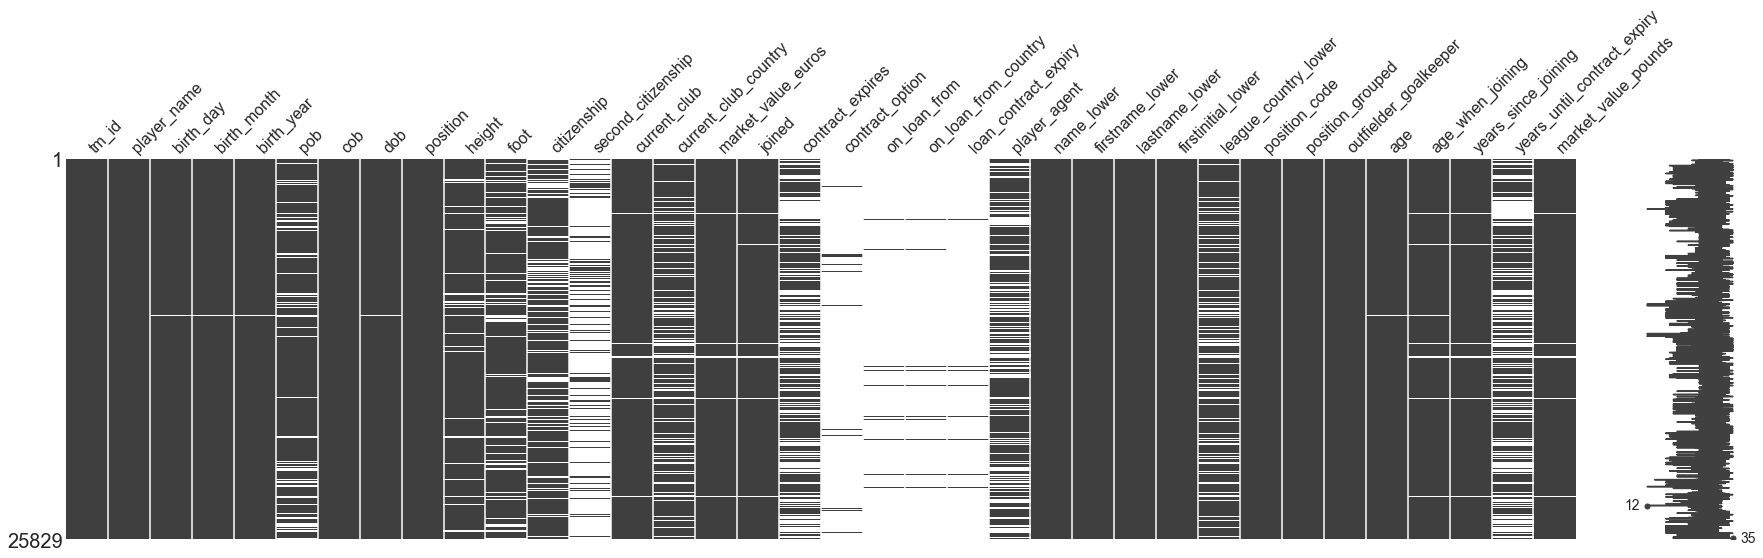

In [64]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm
msno.matrix(df_tm, figsize = (30, 7))

In [65]:
# Counts of missing values
null_value_stats = df_tm.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

birth_day                         29
birth_month                       29
birth_year                        29
pob                             3093
dob                               29
height                          1387
foot                            3632
citizenship                     5574
second_citizenship             20255
current_club                     517
current_club_country            4374
market_value_euros               517
joined                           535
contract_expires                8902
contract_option                24705
on_loan_from                   24827
on_loan_from_country           24827
loan_contract_expiry           25125
player_agent                    7632
league_country_lower            4374
position_code                      1
position_grouped                   1
age                               29
age_when_joining                 553
years_since_joining              535
years_until_contract_expiry     8902
market_value_pounds              517
d

The visualisation shows us very quickly that there very few missing values in either of the outfield or goalkeeper datasets, and therefore this data is ready to be joined to the StatsBomb data.

## <a id='#section4'>4. Fuzzy Match Datasets - Record Linkage</a>

### <a id='#section4.1'>4.1. Introduction</a>
Now we have our two engineered DataFrames for [FBref](https://fbref.com/en/) and [TransferMarkt](https://www.transfermarkt.co.uk/) data, we are now read to merge them to form one dataset.

We are required to join two data sets together that do not have a common unique identifier and are required to use a third-party Python library - [record linkage](https://pypi.org/project/recordlinkage/), installed using pip install recordlinkage. [record linkage](https://pypi.org/project/recordlinkage/) provides a simple interface to link records in or between data sources. 

<b>'Record linkage'</b> is the term used by statisticians, epidemiologists, and historians, among others, to describe the process of joining records from one data source with another that describe the same entity ([source](https://en.wikipedia.org/wiki/Record_linkage)).

Record linkage is necessary when joining different data sets based on entities that may or may not share a common identifier (e.g., database key, URI, National identification number), which may be due to differences in record shape, storage location, or curator style or preference. A data set that has undergone RL-oriented reconciliation may be referred to as being cross-linked. Record linkage is referred to as data linkage in many jurisdictions, but the two are the same process.

The toolkit provides most of the tools needed for record linkage and deduplication. The package contains indexing methods, functions to compare records and classifiers. The package is developed for research and the linking of small or medium sized files.

For a full guide on how to use record linkage, see the official documentation [here](https://recordlinkage.readthedocs.io/en/latest/) and also this worked example by [Chris Moffitt](https://twitter.com/chris1610) [here](https://pbpython.com/record-linking.html)

### <a id='#section4.2'>4.2. Join the FBref and TM Datasets using Record Linkage</a>

The first step is to create a indexer object.

The indexing module is used to make pairs of records. These pairs are called candidate links or candidate matches. There are several indexing algorithms available such as blocking and sorted neighborhood indexing. See the following references for background information about indexation

One key concept is that we can use blocking to limit the number of comparisons. For instance, we know that it is very likely that we only want to compare records that have the same last name, first name initial and birth year. We can use this knowledge to setup a block on these columns in both DataFrames:

In [66]:
# Record Linkage Step 1 - Create an indexer object
indexer = recordlinkage.Index()
indexer.block(left_on = ['firstinitial_lower', 'outfielder_goalkeeper'], 
              right_on = ['firstinitial_lower', 'outfielder_goalkeeper']
             )

<Index>

In [35]:
"""
# Record Linkage Step 1 - Create an indexer object
indexer = recordlinkage.Index()
indexer.block(left_on = ['firstinitial_lower', 'birth_year', 'outfielder_goalkeeper', 'league_country_lower'], 
              right_on = ['firstinitial_lower', 'birth_year', 'outfielder_goalkeeper' 'league_country_lower'])    # removed 'age' as they don't match in the two datasets
"""

"\n# Record Linkage Step 1 - Create an indexer object\nindexer = recordlinkage.Index()\nindexer.block(left_on = ['firstinitial_lower', 'birth_year', 'outfielder_goalkeeper', 'league_country_lower'], \n              right_on = ['firstinitial_lower', 'birth_year', 'outfielder_goalkeeper' 'league_country_lower'])    # removed 'age' as they don't match in the two datasets\n"

The next step is to build up all the potential candidates to check:

In [67]:
# Record Linkage Step 2 - Build up all the potential candidates to check:
candidates = indexer.index(df_sb, df_tm)
print(len(candidates))

811825


Now that we have defined the left and right data sets and all the candidates, we can define how we want to perform the comparison logic using `Compare()`:

In [68]:
# Record Linkage Step 3 - Define how we to perform the comparison logic
compare = recordlinkage.Compare()

compare.string('firstname_lower',
               'firstname_lower',
               method='levenshtein',
               threshold=0.60,
               label='first_name')
compare.string('lastname_lower',
               'lastname_lower',
               method='levenshtein',
               threshold=0.60,
               label='last_name')

features = compare.compute(candidates, df_sb, df_tm)

In [69]:
"""
# Record Linkage Step 3 - Define how we to perform the comparison logic
compare = recordlinkage.Compare()

compare.string('firstname_lower',
               'firstname_lower',
               method='levenshtein',
               threshold=0.60,
               label='first_name')
compare.string('lastname_lower',
               'lastname_lower',
               method='levenshtein',
               threshold=0.60,
               label='last_name')
compare.string('position_grouped',
               'position_description_cleaned',
               method='levenshtein',
               threshold=0.70,
               label='position')
compare.string('nationality_cleaned',
               'cob',
               method='levenshtein',
               threshold=0.70,
               label='nationality')

features = compare.compute(candidates, df_sb, df_tm)
"""

"\n# Record Linkage Step 3 - Define how we to perform the comparison logic\ncompare = recordlinkage.Compare()\n\ncompare.string('firstname_lower',\n               'firstname_lower',\n               method='levenshtein',\n               threshold=0.60,\n               label='first_name')\ncompare.string('lastname_lower',\n               'lastname_lower',\n               method='levenshtein',\n               threshold=0.60,\n               label='last_name')\ncompare.string('position_grouped',\n               'position_description_cleaned',\n               method='levenshtein',\n               threshold=0.70,\n               label='position')\ncompare.string('nationality_cleaned',\n               'cob',\n               method='levenshtein',\n               threshold=0.70,\n               label='nationality')\n\nfeatures = compare.compute(candidates, df_sb, df_tm)\n"

View the potential candidates

In [70]:
# Record Linkage Step 4 - view the potential candidates
features

first_name  last_name
0   4             0.0        0.0
    10            0.0        0.0
    12            0.0        0.0
    25            0.0        0.0
    37            0.0        0.0
...               ...        ...
598 24193         0.0        0.0
    24223         0.0        0.0
    24605         0.0        0.0
    24692         0.0        0.0
    24784         0.0        0.0

[811825 rows x 2 columns]

This DataFrame shows the results of all of the comparisons. There is one row for each row in the Company House and Fan360 DataFrames. The columns correspond to the comparisons we defined. A 1 is a match and 0 is not.

Given the large number of records with no matches, it is a little hard to see how many matches we might have. We can sum up the individual scores to see about the quality of the matches.

In [71]:
# Sum up the individual scores to see the quality of the matches.
features.sum(axis=1).value_counts().sort_index(ascending=False)

2.0       569
1.0     61022
0.0    750234
dtype: int64

To only include high-quality matches, let’s just take all the records with 3 matches out of 3 and create a total score column:

In [72]:
# Show records that have match by index number
potential_matches = features[features.sum(axis=1) == 2].reset_index()
potential_matches

,level_0,level_1,first_name,last_name
0,0,8748,1.0,1.0
1,4,22194,1.0,1.0
2,5,23963,1.0,1.0
3,6,7459,1.0,1.0
4,8,12406,1.0,1.0
...,...,...,...,...
564,586,21699,1.0,1.0
565,587,21756,1.0,1.0
566,588,15405,1.0,1.0
567,589,24328,1.0,1.0


In [74]:
potential_matches['Score'] = potential_matches.loc[:, 'first_name': 'last_name'].sum(axis=1)
#potential_matches['Score'] = potential_matches.loc[:, 'first_name': 'nationality'].sum(axis=1)

# Display DataFrame of potential matches, potential_matches 
potential_matches

,level_0,level_1,first_name,last_name,Score
0,0,8748,1.0,1.0,2.0
1,4,22194,1.0,1.0,2.0
2,5,23963,1.0,1.0,2.0
3,6,7459,1.0,1.0,2.0
4,8,12406,1.0,1.0,2.0
...,...,...,...,...,...
564,586,21699,1.0,1.0,2.0
565,587,21756,1.0,1.0,2.0
566,588,15405,1.0,1.0,2.0
567,589,24328,1.0,1.0,2.0


In [75]:
# Join the FBref Outfielder DataFrame to the potential matches DataFrame
df_merge = pd.merge(potential_matches, df_sb, left_on='level_0', right_index=True)

# Join the TransferMarkt Outfielder DataFrame to the potential matches DataFrame
df_merge = pd.merge(df_merge, df_tm, left_on='level_1', right_index=True)

Now that we've merged the DataFrames, the next step is to clean the DataFrame, reorder the columns, and only keep the columns of interest.

In [76]:
df_merge

,level_0,level_1,first_name,last_name,Score,player_name_x,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper_x,name_lower_x,firstname_lower_x,lastname_lower_x,firstinitial_lower_x,country,country_lower,tm_id,player_name_y,birth_day,birth_month,birth_year,pob,cob,dob,position,height,foot,citizenship,second_citizenship,current_club,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,name_lower_y,firstname_lower_y,lastname_lower_y,firstinitial_lower_y,league_country_lower,position_code,position_grouped,outfielder_goalkeeper_y,age,age_when_joining,years_since_joining,years_until_contract_expiry,market_value_pounds
0,0,8748,1.0,1.0,2.0,Aaron Mooy,Australia,Left Center Midfield,Midfield,Outfielder,aaron mooy,aaron,mooy,a,Australia,australia,123951,aaron mooy,15.0,9.0,1990.0,Sydney,Australia,1990-09-15,midfield - Central Midfield,174.0,right,NaN,Netherlands,shanghai port,china,8500000.0,2020-09-01,2023-07-31,NaN,NaN,NaN,NaN,ICM Stellar Sports,aaron mooy,aaron,mooy,a,china,CM,Midfielder,Outfielder,30.0,29.0,0.0,2.0,7650000.0
1,4,22194,1.0,1.0,2.0,Abdullah Ibrahim Otayf,Saudi Arabia,Center Defensive Midfield,Midfield,Outfielder,abdullah ibrahim otayf,abdullah,otayf,a,Saudi Arabia,saudi arabia,193159,abdullah otayf,3.0,8.0,1992.0,NaN,Saudi Arabia,1992-08-03,midfield - Defensive Midfield,177.0,right,Saudi Arabia,NaN,al-hilal riyadh,saudi arabia,500000.0,2013-02-11,2023-06-30,NaN,NaN,NaN,NaN,NaN,abdullah otayf,abdullah,otayf,a,saudi arabia,CDM,Midfielder,Outfielder,28.0,20.0,8.0,1.0,450000.0
2,5,23963,1.0,1.0,2.0,Abdullahi Shehu,Nigeria,Right Back,Defender,Outfielder,abdullahi shehu,abdullahi,shehu,a,Nigeria,nigeria,262687,abdullahi shehu,12.0,3.0,1993.0,Sokoto,Nigeria,1993-03-12,Defender - Right-Back,181.0,right,Nigeria,NaN,omonia nicosia,cyprus,800000.0,2020-09-19,2022-05-31,NaN,NaN,NaN,NaN,PG SPORTS 99,abdullahi shehu,abdullahi,shehu,a,cyprus,RB,Defender,Outfielder,28.0,27.0,0.0,0.0,720000.0
3,6,7459,1.0,1.0,2.0,Abel Enrique Aguilar Tapia,Colombia,Right Defensive Midfield,Midfield,Outfielder,abel enrique aguilar tapia,abel,tapia,a,Colombia,colombia,45320,ángel di maría,14.0,2.0,1988.0,Rosario,Argentina,1988-02-14,attack - Right Winger,180.0,left,NaN,Italy,paris saint-germain,france,20000000.0,2015-08-06,2022-06-30,Option for a further year,NaN,NaN,NaN,Gestifute,angel di maria,angel,maria,a,france,RW,Forward,Outfielder,33.0,27.0,5.0,0.0,18000000.0
4,8,12406,1.0,1.0,2.0,Adem Ljajić,Serbia,Center Attacking Midfield,Midfield,Outfielder,adem ljajic,adem,ljajic,a,Serbia,serbia,69374,adem ljajic,29.0,9.0,1991.0,Novi Pazar,Jugoslawien (SFR),1991-09-29,midfield - Attacking Midfield,182.0,right,Serbia,NaN,besiktas jk,turkey,6000000.0,2019-07-01,2022-06-30,NaN,NaN,NaN,NaN,LIAN Sports Group,adem ljajic,adem,ljajic,a,turkey,CAM,Midfielder,Outfielder,29.0,27.0,2.0,0.0,5400000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,586,21699,1.0,1.0,2.0,Yuri Zhirkov,Russia,Left Back,Defender,Outfielder,yuri zhirkov,yuri,zhirkov,y,Russia,russia,16760,yuri zhirkov,20.0,8.0,1983.0,Tambov,UdSSR,1983-08-20,Defender - Left-Back,180.0,left,Russia,NaN,without club,NaN,300000.0,2021-07-01,NaN,NaN,NaN,NaN,NaN,not clarified,yuri zhirkov,yuri,zhirkov,y,NaN,LB,Defender,Outfielder,37.0,37.0,0.0,NaN,270000.0
565,587,21756,1.0,1.0,2.0,Yury Gazinskiy,Russia,Right Defensive Midfield,Midfield,Outfielder,yury gazinskiy,yury,gazinskiy,y,Russia,russia,159957,yuri gazinskiy,20.0,7.0,1989.0,"Komsomoljsk-na-Amure, Khabarovsk Region",UdSSR,1989-07-20,midfield - Central Midfield,184.0,right,Russia,NaN,fk krasnodar,russia,4000000.0,2013-07-01,2022-06-30,NaN,NaN,NaN,NaN,NaN,yuri gazinskiy,yuri,gazinskiy,y,russia,CM,Midfielder,Outfielder,32.0,23.0,8.0,0.0,3600000.0
566,588,15405,1.0,1.0,2.0,Yus

In [77]:
df_merge.shape

(569, 52)

In [97]:
cols_merge = ['tm_id',
               'player_name_x',
               'firstname_lower_x',
               'lastname_lower_x',
               'primary_position_name',
               'outfielder_goalkeeper_x',
               'team_name',
               'birth_day',
               'birth_month',
               'birth_year',
               'pob',
               'cob',
               'dob',
               'age',
               'age_when_joining',
               'years_since_joining',
               'years_until_contract_expiry',
               'height',
               'foot',
               'second_citizenship',
               'current_club',
               'current_club_country',
               'market_value_euros',
               'market_value_pounds',
               'joined',
               'contract_expires',
               'contract_option',
               'on_loan_from',
               'on_loan_from_country',
               'loan_contract_expiry',
               'player_agent',
               'Score']

# Create more concise DataFrame using only columns of interest
df_merge_select = df_merge[cols_merge]

# Drop duplicates
df_merge_select = df_merge_select.drop_duplicates()

# Order rows by 'value' and matching 'Score' decending (i.e. best matches of 4 out of 4 at the top) 
df_merge_select = df_merge_select.sort_values(by=['market_value_pounds', 'player_name_x'], ascending=[False, True])

In [98]:
df_merge_select

,tm_id,player_name_x,firstname_lower_x,lastname_lower_x,primary_position_name,outfielder_goalkeeper_x,team_name,birth_day,birth_month,birth_year,pob,cob,dob,age,age_when_joining,years_since_joining,years_until_contract_expiry,height,foot,second_citizenship,current_club,current_club_country,market_value_euros,market_value_pounds,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,Score
174,132098,Harry Kane,harry,kane,Left Center Forward,Outfielder,England,28.0,7.0,1993.0,London,England,1993-07-28,27.0,17.0,10.0,2.0,188.0,right,NaN,tottenham hotspur,england,120000000.0,108000000.0,2011-01-01,2024-06-30,NaN,NaN,NaN,NaN,CK66,2.0
269,88755,Kevin De Bruyne,kevin,bruyne,Right Center Midfield,Outfielder,Belgium,28.0,6.0,1991.0,Drongen,Belgium,1991-06-28,30.0,24.0,5.0,3.0,181.0,right,NaN,manchester city,england,100000000.0,90000000.0,2015-08-30,2025-06-30,NaN,NaN,NaN,NaN,NaN,2.0
361,148455,Mohamed Salah,mohamed,salah,Right Center Forward,Outfielder,Egypt,15.0,6.0,1992.0,"Nagrig, Basyoun",Egypt,1992-06-15,29.0,25.0,4.0,1.0,175.0,left,NaN,liverpool fc,england,100000000.0,90000000.0,2017-07-01,2023-06-30,NaN,NaN,NaN,NaN,NaN,2.0
77,240306,Bruno Miguel Borges Fernandes,bruno,fernandes,Left Midfield,Outfielder,Portugal,8.0,9.0,1994.0,Maia,Portugal,1994-09-08,26.0,25.0,1.0,3.0,179.0,right,NaN,manchester united,england,90000000.0,81000000.0,2020-01-29,2025-06-30,player option 1 year,NaN,NaN,NaN,MRP.POSITIONUMBER,2.0
232,161056,Joshua Kimmich,joshua,kimmich,Right Back,Outfielder,Germany,8.0,2.0,1995.0,Rottweil,Germany,1995-02-08,26.0,20.0,6.0,1.0,177.0,right,NaN,bayern munich,germany,90000000.0,81000000.0,2015-07-02,2023-06-30,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,462251,José Martín Cáceres Silva,jose,silva,Right Back,Outfielder,Uruguay,4.0,2.0,1999.0,Porto,Portugal,1999-02-04,22.0,NaN,NaN,NaN,184.0,right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
283,240338,Luis Jan Piers Advíncula Castrillón,luis,castrillon,Right Back,Outfielder,Peru,8.0,8.0,1996.0,Napoli,Italy,1996-08-08,24.0,NaN,NaN,NaN,188.0,left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
316,540938,Mario Gavranović,mario,gavranovic,Center Forward,Outfielder,Switzerland,5.0,2.0,1999.0,Zagreb,Croatia,1999-02-05,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
320,319176,Mario Gómez García,mario,garcia,Center Forward,Outfielder,Germany,11.0,4.0,1999.0,Karlovy Vary,Czech Republic,1999-04-11,22.0,NaN,NaN,NaN,184.0,right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [103]:
# Join the Company House DataFrame to the potential matches DataFrame
df_final = pd.merge(df_sb, df_merge_select, how='left', left_on=['firstname_lower', 'lastname_lower', 'outfielder_goalkeeper'], right_on=['firstname_lower_x', 'lastname_lower_x', 'outfielder_goalkeeper_x'])

# Drop duplicates
df_final = df_final.drop_duplicates()

In [104]:
df_final.head()

,player_name,team_name_x,primary_position_name_x,primary_position_name_grouped,outfielder_goalkeeper,name_lower,firstname_lower,lastname_lower,firstinitial_lower,country,country_lower,tm_id,player_name_x,firstname_lower_x,lastname_lower_x,primary_position_name_y,outfielder_goalkeeper_x,team_name_y,birth_day,birth_month,birth_year,pob,cob,dob,age,age_when_joining,years_since_joining,years_until_contract_expiry,height,foot,second_citizenship,current_club,current_club_country,market_value_euros,market_value_pounds,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,Score
0,Aaron Mooy,Australia,Left Center Midfield,Midfield,Outfielder,aaron mooy,aaron,mooy,a,Australia,australia,123951.0,Aaron Mooy,aaron,mooy,Left Center Midfield,Outfielder,Australia,15.0,9.0,1990.0,Sydney,Australia,1990-09-15,30.0,29.0,0.0,2.0,174.0,right,Netherlands,shanghai port,china,8500000.0,7650000.0,2020-09-01,2023-07-31,NaN,NaN,NaN,NaN,ICM Stellar Sports,2.0
1,Abdalla Mahmoud El Said Bekhit,Egypt,Center Attacking Midfield,Midfield,Outfielder,abdalla mahmoud el said bekhit,abdalla,bekhit,a,Egypt,egypt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abdiel Arroyo Molinar,Panama,Left Center Midfield,Midfield,Outfielder,abdiel arroyo molinar,abdiel,molinar,a,Panama,panama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdullah Ibrahim Al Maiouf,Saudi Arabia,Goalkeeper,Goalkeeper,Goalkeeper,abdullah ibrahim al maiouf,abdullah,maiouf,a,Saudi Arabia,saudi arabia,147866.0,Abdullah Ibrahim Al Maiouf,abdullah,maiouf,Goalkeeper,Goalkeeper,Saudi Arabia,23.0,1.0,1987.0,Al-Riyadh,Saudi Arabia,1987-01-23,34.0,29.0,5.0,1.0,187.0,right,NaN,al-hilal riyadh,saudi arabia,100000.0,90000.0,2016-07-12,2023-06-30,NaN,NaN,NaN,NaN,NaN,2.0
4,Abdullah Ibrahim Otayf,Saudi Arabia,Center Defensive Midfield,Midfield,Outfielder,abdullah ibrahim otayf,abdullah,otayf,a,Saudi Arabia,saudi arabia,193159.0,Abdullah Ibrahim Otayf,abdullah,otayf,Center Defensive Midfield,Outfielder,Saudi Arabia,3.0,8.0,1992.0,NaN,Saudi Arabia,1992-08-03,28.0,20.0,8.0,1.0,177.0,right,NaN,al-hilal riyadh,saudi arabia,500000.0,450000.0,2013-02-11,2023-06-30,NaN,NaN,NaN,NaN,NaN,2.0


In [105]:
df_sb.shape

(600, 11)

In [106]:
df_final.shape

(747, 43)

In [114]:
# Select columns of interest
cols_final = ['player_name',
              'team_name_x',
              'primary_position_name_x',
              'primary_position_name_grouped',
              'outfielder_goalkeeper',
              'age',
              'dob',
              'pob',
              'cob',
              'second_citizenship',
              'current_club',
              'current_club_country',
              'height',
              'foot',
              'market_value_euros',
              'market_value_pounds',
              'joined',
              'age_when_joining',
              'years_since_joining',
              'contract_expires',
              'years_until_contract_expiry',
              'contract_option',
              'on_loan_from',
              'on_loan_from_country',
              'loan_contract_expiry',
              'player_agent'
             ]


# Create more concise DataFrame using only columns of interest
df_final = df_final[cols_final]

# Order rows by 'company_id_ch' ascending and matching score decending (i.e. best matches of 5 out of 5 at the top) 
df_final = df_final.sort_values(by=['market_value_pounds', 'player_name'], ascending=[False, True])

In [115]:
df_final.head()

,player_name,team_name_x,primary_position_name_x,primary_position_name_grouped,outfielder_goalkeeper,age,dob,pob,cob,second_citizenship,current_club,current_club_country,height,foot,market_value_euros,market_value_pounds,joined,age_when_joining,years_since_joining,contract_expires,years_until_contract_expiry,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
238,Harry Kane,England,Left Center Forward,Forward,Outfielder,27.0,1993-07-28,London,England,NaN,tottenham hotspur,england,188.0,right,120000000.0,108000000.0,2011-01-01,17.0,10.0,2024-06-30,2.0,NaN,NaN,NaN,NaN,CK66
365,Kevin De Bruyne,Belgium,Right Center Midfield,Midfield,Outfielder,30.0,1991-06-28,Drongen,Belgium,NaN,manchester city,england,181.0,right,100000000.0,90000000.0,2015-08-30,24.0,5.0,2025-06-30,3.0,NaN,NaN,NaN,NaN,NaN
485,Mohamed Salah,Egypt,Right Center Forward,Forward,Outfielder,29.0,1992-06-15,"Nagrig, Basyoun",Egypt,NaN,liverpool fc,england,175.0,left,100000000.0,90000000.0,2017-07-01,25.0,4.0,2023-06-30,1.0,NaN,NaN,NaN,NaN,NaN
97,Bruno Miguel Borges Fernandes,Portugal,Left Midfield,Midfield,Outfielder,26.0,1994-09-08,Maia,Portugal,NaN,manchester united,england,179.0,right,90000000.0,81000000.0,2020-01-29,25.0,1.0,2025-06-30,3.0,player option 1 year,NaN,NaN,NaN,MRP.POSITIONUMBER
318,Joshua Kimmich,Germany,Right Back,Defender,Outfielder,26.0,1995-02-08,Rottweil,Germany,NaN,bayern munich,germany,177.0,right,90000000.0,81000000.0,2015-07-02,20.0,6.0,2023-06-30,1.0,NaN,NaN,NaN,NaN,NaN


In [117]:
# Rename columns
df_final = df_final.rename(columns={'team_name_x': 'team_name',
                                    'primary_position_name_x': 'primary_position_name'
                                   }
                          )

In [118]:
df_final.shape

(747, 26)

#### Dedupe DataFrame
Some duplicates. Easy fix for now is to keep the highest value version of each player.

In [134]:
df_final = df_final.sort_values(['player_name', 'market_value_euros'], ascending=[True, False])
df_final_dedupe = df_final.drop_duplicates(subset=['player_name'], keep='first')

In [135]:
df_final_dedupe.shape

(600, 26)

In [136]:
df_final_dedupe

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper,age,dob,pob,cob,second_citizenship,current_club,current_club_country,height,foot,market_value_euros,market_value_pounds,joined,age_when_joining,years_since_joining,contract_expires,years_until_contract_expiry,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
0,Aaron Mooy,Australia,Left Center Midfield,Midfield,Outfielder,30.0,1990-09-15,Sydney,Australia,Netherlands,shanghai port,china,174.0,right,8500000.0,7650000.0,2020-09-01,29.0,0.0,2023-07-31,2.0,NaN,NaN,NaN,NaN,ICM Stellar Sports
1,Abdalla Mahmoud El Said Bekhit,Egypt,Center Attacking Midfield,Midfield,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abdiel Arroyo Molinar,Panama,Left Center Midfield,Midfield,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdullah Ibrahim Al Maiouf,Saudi Arabia,Goalkeeper,Goalkeeper,Goalkeeper,34.0,1987-01-23,Al-Riyadh,Saudi Arabia,NaN,al-hilal riyadh,saudi arabia,187.0,right,100000.0,90000.0,2016-07-12,29.0,5.0,2023-06-30,1.0,NaN,NaN,NaN,NaN,NaN
4,Abdullah Ibrahim Otayf,Saudi Arabia,Center Defensive Midfield,Midfield,Outfielder,28.0,1992-08-03,NaN,Saudi Arabia,NaN,al-hilal riyadh,saudi arabia,177.0,right,500000.0,450000.0,2013-02-11,20.0,8.0,2023-06-30,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,İlkay Gündoğan,Germany,Left Defensive Midfield,Midfield,Outfielder,30.0,1990-10-24,Gelsenkirchen,Germany,NaN,manchester city,england,180.0,right,40000000.0,36000000.0,2016-07-01,25.0,5.0,2023-06-30,1.0,NaN,NaN,NaN,NaN,KIN Partners
743,Łukasz Fabiański,Poland,Goalkeeper,Goalkeeper,Goalkeeper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,Łukasz Piszczek,Poland,Right Center Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745,Łukasz Teodorczyk,Poland,Center Attacking Midfield,Midfield,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
df_null = df_final_dedupe[df_final_dedupe['market_value_euros'].isnull()]

In [138]:
df_null

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper,age,dob,pob,cob,second_citizenship,current_club,current_club_country,height,foot,market_value_euros,market_value_pounds,joined,age_when_joining,years_since_joining,contract_expires,years_until_contract_expiry,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
1,Abdalla Mahmoud El Said Bekhit,Egypt,Center Attacking Midfield,Midfield,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abdiel Arroyo Molinar,Panama,Left Center Midfield,Midfield,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Achraf Hakimi Mouh,Morocco,Left Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Adolfo Abdiel Machado,Panama,Right Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Ahmed Fathy Abdel Meneim Ibrahim,Egypt,Right Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,Édison Michael Flores Peralta,Peru,Left Defensive Midfield,Midfield,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,Óscar Esau Duarte Gaitán,Costa Rica,Left Center Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
743,Łukasz Fabiański,Poland,Goalkeeper,Goalkeeper,Goalkeeper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,Łukasz Piszczek,Poland,Right Center Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
#df_null.to_csv(data_dir + '/test_null_tm_fbref.csv', index=None, header=True)

Let's export the merged DataFrame, `df_final` as a CSV file.

In [140]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir, 'sb', 'engineered', 'combined', 'wc2018', 'sb_events_grouped_market_value.csv')):
    df_final_dedupe.to_csv(os.path.join(data_dir, 'sb', 'engineered', 'combined', 'wc2018', 'sb_events_grouped_market_value.csv'), index=None, header=True)
else:
    pass

## <a id='#section5'>5. Exploratory Data Analysis</a>

In [141]:
df_final_dedupe.head()

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper,age,dob,pob,cob,second_citizenship,current_club,current_club_country,height,foot,market_value_euros,market_value_pounds,joined,age_when_joining,years_since_joining,contract_expires,years_until_contract_expiry,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
0,Aaron Mooy,Australia,Left Center Midfield,Midfield,Outfielder,30.0,1990-09-15,Sydney,Australia,Netherlands,shanghai port,china,174.0,right,8500000.0,7650000.0,2020-09-01,29.0,0.0,2023-07-31,2.0,NaN,NaN,NaN,NaN,ICM Stellar Sports
1,Abdalla Mahmoud El Said Bekhit,Egypt,Center Attacking Midfield,Midfield,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abdiel Arroyo Molinar,Panama,Left Center Midfield,Midfield,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdullah Ibrahim Al Maiouf,Saudi Arabia,Goalkeeper,Goalkeeper,Goalkeeper,34.0,1987-01-23,Al-Riyadh,Saudi Arabia,NaN,al-hilal riyadh,saudi arabia,187.0,right,100000.0,90000.0,2016-07-12,29.0,5.0,2023-06-30,1.0,NaN,NaN,NaN,NaN,NaN
4,Abdullah Ibrahim Otayf,Saudi Arabia,Center Defensive Midfield,Midfield,Outfielder,28.0,1992-08-03,NaN,Saudi Arabia,NaN,al-hilal riyadh,saudi arabia,177.0,right,500000.0,450000.0,2013-02-11,20.0,8.0,2023-06-30,1.0,NaN,NaN,NaN,NaN,NaN


In [130]:
df_final_dedupe[df_final_dedupe['player_name'] == 'Harry Kane']

,player_name,team_name,primary_position_name,primary_position_name_grouped,outfielder_goalkeeper,age,dob,pob,cob,second_citizenship,current_club,current_club_country,height,foot,market_value_euros,market_value_pounds,joined,age_when_joining,years_since_joining,contract_expires,years_until_contract_expiry,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
238,Harry Kane,England,Left Center Forward,Forward,Outfielder,27.0,1993-07-28,London,England,NaN,tottenham hotspur,england,188.0,right,120000000.0,108000000.0,2011-01-01,17.0,10.0,2024-06-30,2.0,NaN,NaN,NaN,NaN,CK66


## <a id='#section6'>6. Summary</a>
This notebook matches data from [StatsBomb](https://statsbomb.com/) and [TransferMarkt](https://www.transfermarkt.co.uk/),  through [record-linkage](https://pypi.org/project/recordlinkage/), to create one, unified source of information, that can be used to enrich StatsBomb data with financial valuation data.

## <a id='#section7'>7. Next Steps</a>
This data is now ready to be exported and analysed in further Jupyter notebooks or Tableau.

## <a id='#section8'>8. References</a>

#### Fuzzy Matching through Record Linkage
*    Record Linkage Wiki: https://en.wikipedia.org/wiki/Record_linkage
*    [Official Record Linkage documentation web](https://recordlinkage.readthedocs.io/en/latest/about.html)
*    [Official Record Linkage documentation PDF](https://readthedocs.org/projects/recordlinkage/downloads/pdf/stable/)
     -    [0. Preprocessing](https://recordlinkage.readthedocs.io/en/latest/ref-preprocessing.html)
     -    [1. Indexing](https://recordlinkage.readthedocs.io/en/latest/ref-index.html)
     -    [2. Comparing](https://recordlinkage.readthedocs.io/en/latest/ref-compare.html)
     -    [3. Classification](https://recordlinkage.readthedocs.io/en/latest/ref-classifiers.html)
     -    [4. Evaluation](https://recordlinkage.readthedocs.io/en/latest/ref-evaluation.html)
*    Evaluation:https://recordlinkage.readthedocs.io/en/latest/ref-evaluation.html
*    Python Tools for Record Linking and Fuzzy Matching by Chris Moffitt: https://pbpython.com/record-linking.html
*    [Python Tools for Record Linking and Fuzzy Matching](https://pbpython.com/record-linking.html). For more information for record linking and fuzzy matching.
*    [Python Package Index (PyPI) Jellyfish library](https://pypi.org/project/jellyfish/).

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)